In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

- https://www.youtube.com/watch?v=ElmBrKyMXxs
- https://github.com/hans/ipython-notebooks/blob/master/tf/TF%20tutorial.ipynb
- https://github.com/ematvey/tensorflow-seq2seq-tutorials

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_seq2seq_data_provider import PriceHistorySeq2SeqDataProvider
from data_providers.price_history_dataset_generator import PriceHistoryDatasetGenerator
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from models.model_21_price_history_seq2seq_dyn_dec_ins import PriceHistorySeq2SeqDynDecIns
from os.path import isdir
from cost_functions.huber_loss import huber_loss

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
epochs = 10

num_features = 1
num_units = 400 #state size

input_len = 60
target_len = 30

batch_size = 50 #47
#trunc_backprop_len = ??
with_EOS = False

In [5]:
total_train_size = 57994
train_size = 6400 
test_size = 1282

### Once generate data

In [95]:
data_folder = '../../../../Dropbox/data'
assert isdir(data_folder)

In [96]:
data_path = data_folder + '/price_history'

In [8]:
#npz_full_train = data_path + '/price_history_03_dp_60to30_train.npz'
#npz_full_train = data_path + '/price_history_60to30_targets_normed_train.npz'

#npz_train = data_path + '/price_history_03_dp_60to30_57980_train.npz'
#npz_train = data_path + '/price_history_03_dp_60to30_6400_train.npz'
npz_train = data_path + '/price_history_60to30_6400_targets_normed_train.npz'

#npz_test = data_path + '/price_history_03_dp_60to30_test.npz'
npz_test = data_path + '/price_history_60to30_targets_normed_test.npz'

### Step 1 - collect data

In [9]:
dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_train, batch_size=batch_size, with_EOS=with_EOS)
dp.inputs.shape, dp.targets.shape

((6400, 60, 1), (6400, 30))

In [10]:
aa, bb = dp.next()
aa.shape, bb.shape

((50, 60, 1), (50, 30))

### Step 2 - Build model

In [11]:
model = PriceHistorySeq2SeqDynDecIns(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [12]:
graph = model.getGraph(batch_size=batch_size,
                       num_units=num_units,
                       input_len=input_len,
                       target_len=target_len)

60
Tensor("inputs/unstack:0", shape=(50, 1), dtype=float32)

Tensor("encoder_rnn_layer/rnn/gru_cell_59/add:0", shape=(50, 400), dtype=float32)

time
Tensor("decoder_rnn_layer/rnn/while/add:0", shape=(), dtype=int32)

decoder_final_loop_state
Tensor("decoder_rnn_layer/rnn/while/Exit_5:0", shape=(50, 30), dtype=float32)


Tensor("error/Select:0", shape=(50, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)
Tensor("error/Mean:0", shape=(), dtype=float32)



In [13]:
show_graph(graph)

### Step 3 training the network

RECALL: baseline is around 4 for huber loss for current problem, anything above 4 should be considered as major errors

In [14]:
#rnn_cell = PriceHistorySeq2SeqCV.RNN_CELLS.GRU
#cross_val_n_splits = 5
epochs = 30
epochs, num_units, batch_size

(30, 400, 50)

In [15]:
#set(factors(train_size)).intersection(factors(train_size/5))

In [16]:
best_learning_rate = 1e-3 #0.0026945952539362472
keep_prob_input = 0.7
lamda2 = 1e-2

In [17]:
def experiment():
    return model.run(npz_path=npz_train,
             epochs=epochs,
             batch_size = batch_size,
             num_units = num_units,
             input_len=input_len,
             target_len=target_len,
             learning_rate = best_learning_rate,
             preds_gather_enabled=True,
             keep_prob_input = keep_prob_input,
             lamda2=lamda2,
            )

Recall that without batch normalization within 10 epochs with num units 400 and batch_size 64 we reached at 4.940
and with having the decoder inputs NOT filled from the outputs

In [18]:
%%time
dyn_stats, preds_dict = get_or_run_nn(
  experiment,
  filename='021_seq2seq_60to30_dyn_dec_ins_epochs{}_learning_rate_{:.4f}_prob_input{}_lamda2_{}'.format(
      epochs, best_learning_rate, keep_prob_input, lamda2
  ), nn_runs_folder= data_folder + '/nn_runs')

CPU times: user 716 ms, sys: 4 ms, total: 720 ms
Wall time: 717 ms


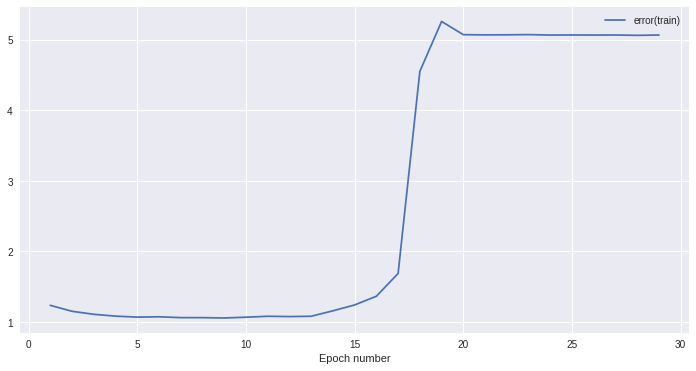

In [19]:
dyn_stats.plotStats()
plt.show()

In [20]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [21]:
ind = np.argmin(r2_scores)
ind

4398

In [22]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [23]:
r2_score(y_true=reals, y_pred=preds)

-7.4717219964671917e+30

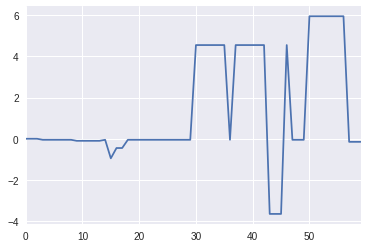

In [24]:
sns.tsplot(data=dp.inputs[ind].flatten())

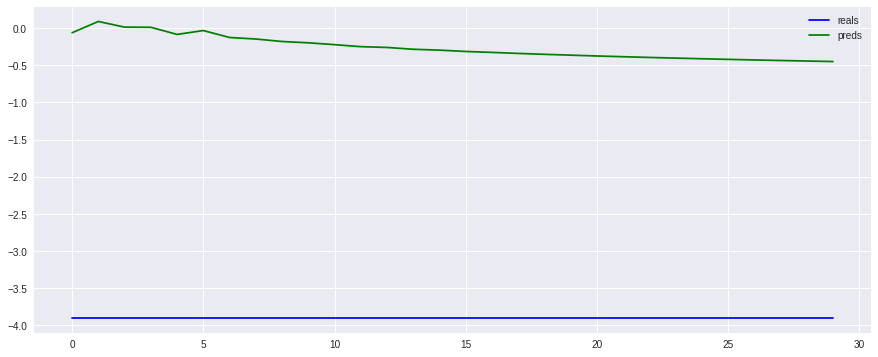

In [25]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [26]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 13.4 s, sys: 128 ms, total: 13.6 s
Wall time: 13.3 s


In [27]:
np.mean(dtw_scores)

162.57913656256787

In [28]:
coint(preds, reals)

(1.8883101905635189, 1.0, array([-4.31395736, -3.55493606, -3.19393252]))

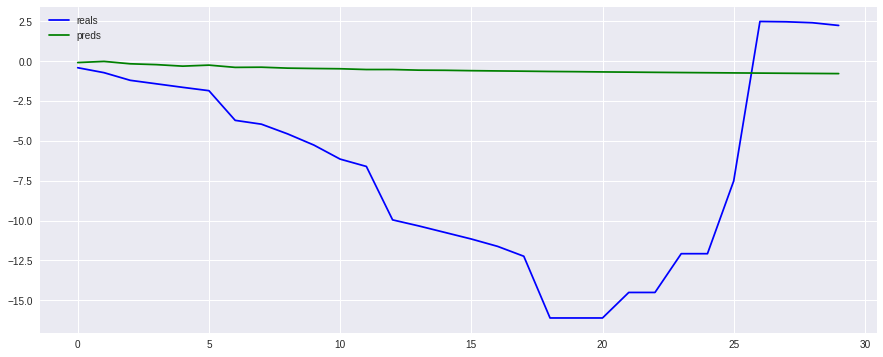

In [29]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [30]:
average_huber_loss = np.mean([np.mean(huber_loss(dp.targets[ind], preds_dict[ind]))
                              for ind in range(len(dp.targets))])
average_huber_loss

5.0690297985951851

#### Conclusion
???

## Without L2, Dropout and Batch Norm but with ELU

In [31]:
epochs = 20
num_units = 400
activation = tf.nn.elu
epochs, num_units, batch_size

(20, 400, 50)

In [32]:
best_learning_rate = 1e-3 #0.0026945952539362472
batch_norm_enabled = False

In [33]:
def experiment():
    return model.run(npz_path=npz_train,
             epochs=epochs,
             batch_size = batch_size,
             num_units = num_units,
             input_len=input_len,
             target_len=target_len,
             learning_rate = best_learning_rate,
             preds_gather_enabled = True,
             batch_norm_enabled = batch_norm_enabled,
             activation = activation,
            )

Recall that without batch normalization within 10 epochs with num units 400 and batch_size 64 we reached at 4.940
and with having the decoder inputs NOT filled from the outputs

In [35]:
%%time
dyn_stats, preds_dict = get_or_run_nn(
  experiment,
  filename='021_seq2seq_60to30_dyn_dec_ins_epochs{}_learning_rate_{:.4f}_batch_norm_{}_num_units{}_elu'.format(
      epochs, best_learning_rate, batch_norm_enabled, num_units
  ), nn_runs_folder= data_folder + '/nn_runs')

CPU times: user 736 ms, sys: 4 ms, total: 740 ms
Wall time: 768 ms


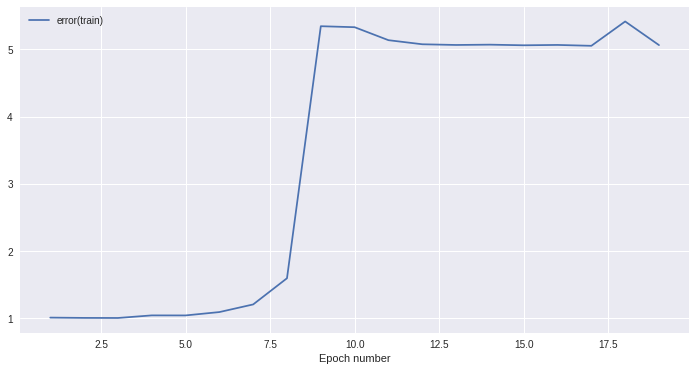

In [36]:
dyn_stats.plotStats()
plt.show()

In [37]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [38]:
ind = np.argmin(r2_scores)
ind

4398

In [39]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [40]:
r2_score(y_true=reals, y_pred=preds)

-6.9681049370646585e+30

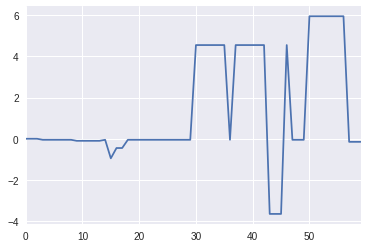

In [41]:
sns.tsplot(data=dp.inputs[ind].flatten())

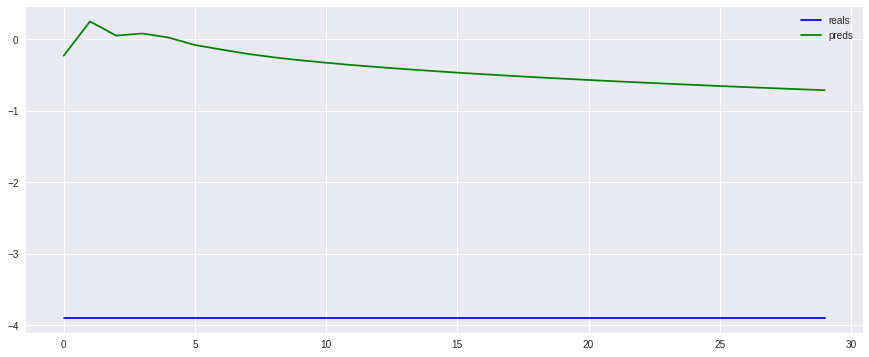

In [42]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [43]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 13.3 s, sys: 100 ms, total: 13.4 s
Wall time: 13.3 s


In [44]:
np.mean(dtw_scores)

162.38774521500974

In [45]:
coint(preds, reals)

(1.6693425943586093, 1.0, array([-4.31395736, -3.55493606, -3.19393252]))

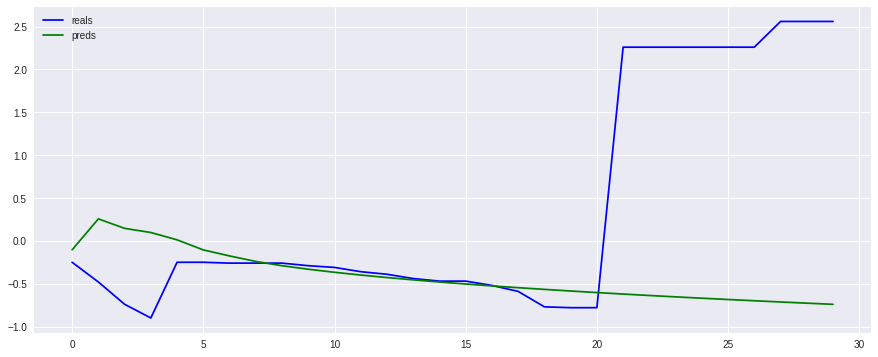

In [46]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [47]:
average_huber_loss = np.mean([np.mean(huber_loss(dp.targets[ind], preds_dict[ind]))
                              for ind in range(len(dp.targets))])
average_huber_loss

5.0605618963911461

#### Conclusion
???

# Trying again with zero as first input to the decoder

In [48]:
epochs = 20
num_units = 400
activation = tf.nn.elu
epochs, num_units, batch_size

(20, 400, 50)

In [49]:
best_learning_rate = 1e-3 #0.0026945952539362472
batch_norm_enabled = False

In [50]:
def experiment():
    return model.run(npz_path=npz_train,
             epochs=epochs,
             batch_size = batch_size,
             num_units = num_units,
             input_len=input_len,
             target_len=target_len,
             learning_rate = best_learning_rate,
             preds_gather_enabled = True,
             batch_norm_enabled = batch_norm_enabled,
             activation = activation,
            )

Recall that without batch normalization within 10 epochs with num units 400 and batch_size 64 we reached at 4.940
and with having the decoder inputs NOT filled from the outputs

In [51]:
%%time
dyn_stats, preds_dict = get_or_run_nn(
  experiment,
  filename=
    '021_seq2seq_60to30_dyn_dec_ins_epochs{}_learning_rate_{:.4f}_batch_norm_{}_num_units{}_elu_zero_first'.format(
      epochs, best_learning_rate, batch_norm_enabled, num_units
  ), nn_runs_folder= data_folder + '/nn_runs')

CPU times: user 720 ms, sys: 8 ms, total: 728 ms
Wall time: 768 ms


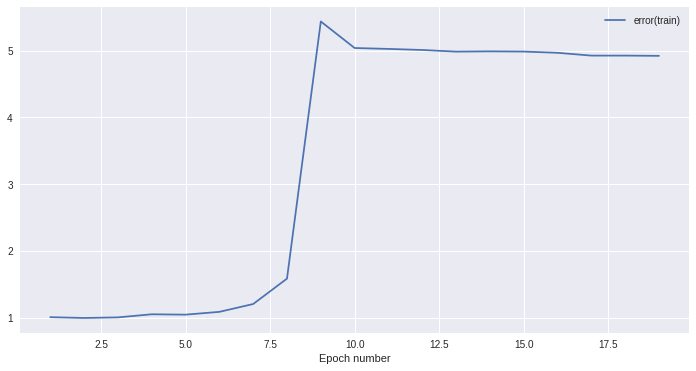

In [52]:
dyn_stats.plotStats()
plt.show()

In [53]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [54]:
ind = np.argmin(r2_scores)
ind

4398

In [55]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [56]:
r2_score(y_true=reals, y_pred=preds)

-7.7103743854103354e+30

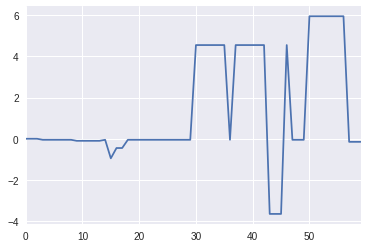

In [57]:
sns.tsplot(data=dp.inputs[ind].flatten())

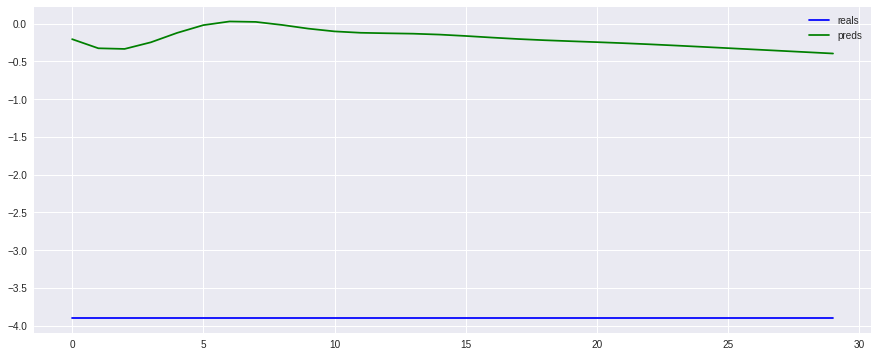

In [58]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [59]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 13.1 s, sys: 84 ms, total: 13.2 s
Wall time: 13.1 s


In [60]:
np.mean(dtw_scores)

158.37255693489087

In [61]:
coint(preds, reals)

(0.42509878133227852,
 0.99209991187800051,
 array([-4.31395736, -3.55493606, -3.19393252]))

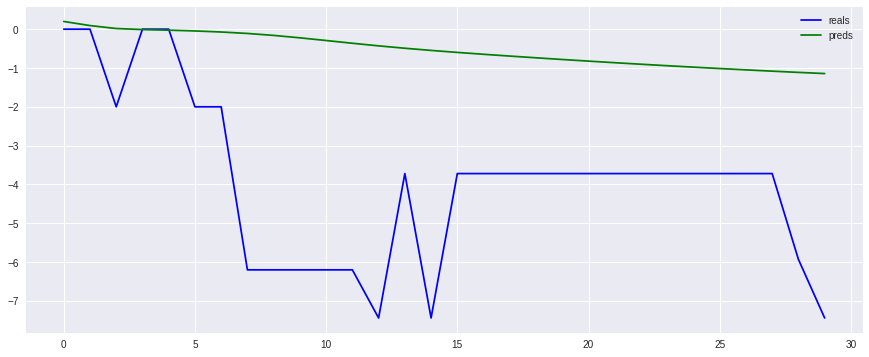

In [62]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [63]:
average_huber_loss = np.mean([np.mean(huber_loss(dp.targets[ind], preds_dict[ind]))
                              for ind in range(len(dp.targets))])
average_huber_loss

4.9666451508549194

#### Conclusion
???

# Let's try again but without normalized targets

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [98]:
num_units = 400 #state size

input_len = 60
target_len = 30

batch_size = 50
#trunc_backprop_len = ??
with_EOS = False

In [99]:
total_train_size = 57994
train_size = 6400 
test_size = 1282

### Once generate data

In [100]:
#npz_full_train = data_path + '/price_history_03_dp_60to30_train.npz'
#npz_full_train = data_path + '/price_history_60to30_targets_normed_train.npz'

#npz_train = data_path + '/price_history_03_dp_60to30_57980_train.npz'
npz_train = data_path + '/price_history_03_dp_60to30_6400_train.npz'
#npz_train = data_path + '/price_history_60to30_6400_targets_normed_train.npz'

#npz_test = data_path + '/price_history_03_dp_60to30_test.npz'
npz_test = data_path + '/price_history_60to30_targets_normed_test.npz'

### Step 1 - collect data

In [101]:
dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_train, batch_size=batch_size, with_EOS=with_EOS)
dp.inputs.shape, dp.targets.shape

((6400, 60, 1), (6400, 30))

In [102]:
aa, bb = dp.next()
aa.shape, bb.shape

((50, 60, 1), (50, 30))

### Step 2 - Build model

In [103]:
model = PriceHistorySeq2SeqDynDecIns(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [104]:
# graph = model.getGraph(batch_size=batch_size,
#                        num_units=num_units,
#                        input_len=input_len,
#                        target_len=target_len)

In [105]:
#show_graph(graph)

### Step 3 training the network

RECALL: baseline is around 4 for huber loss for current problem, anything above 4 should be considered as major errors

In [106]:
epochs = 20
epochs, num_units, batch_size

(20, 400, 50)

In [107]:
#set(factors(train_size)).intersection(factors(train_size/5))

In [108]:
learning_rate = 1e-4 #0.0026945952539362472
decoder_first_input = PriceHistorySeq2SeqDynDecIns.DECODER_FIRST_INPUT.PREVIOUS_INPUT
activation = tf.nn.elu
batch_norm_enabled = False

In [109]:
def experiment():
    return model.run(npz_path=npz_train,
             epochs=epochs,
             batch_size = batch_size,
             num_units = num_units,
             input_len=input_len,
             target_len=target_len,
             learning_rate = learning_rate,
             preds_gather_enabled=True,
             batch_norm_enabled = batch_norm_enabled,
             decoder_first_input = decoder_first_input,
             activation = activation,
            )

In [110]:
%%time
dyn_stats, preds_dict = get_or_run_nn(
  experiment,
  filename=
'021_seq2seq_60to30_dyn_dec_ins_epochs{}_learning_rate{}_not_normed_targets'.format(
      epochs, learning_rate,
  ), nn_runs_folder= data_folder + '/nn_runs')

CPU times: user 744 ms, sys: 4 ms, total: 748 ms
Wall time: 746 ms


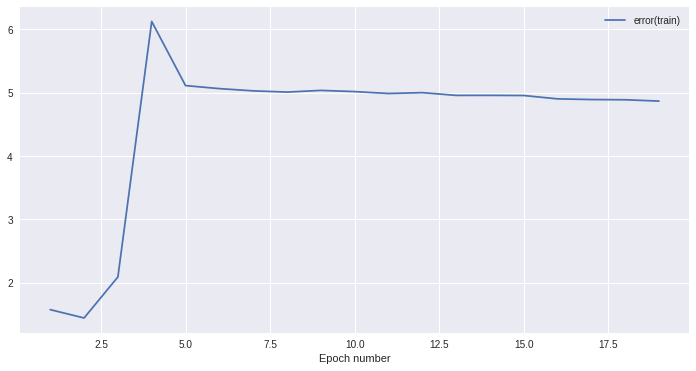

In [111]:
dyn_stats.plotStats()
plt.show()

In [112]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [113]:
ind = np.argmin(r2_scores)
ind

2205

In [114]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [115]:
r2_score(y_true=reals, y_pred=preds)

-1.0281954239183587e+31

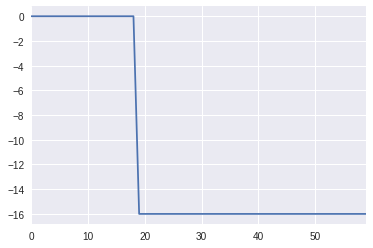

In [116]:
sns.tsplot(data=dp.inputs[ind].flatten())

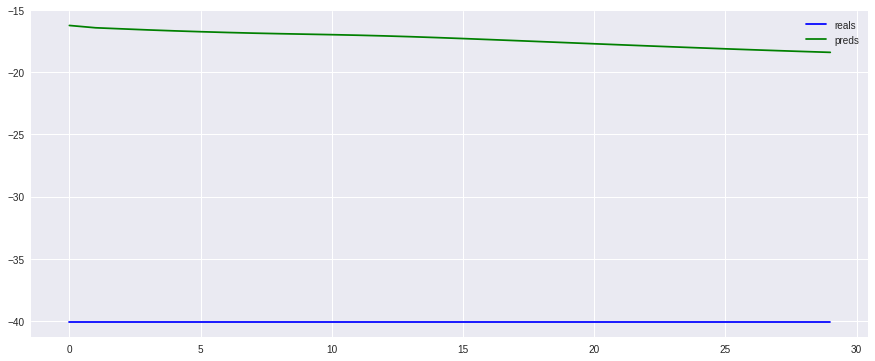

In [117]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [118]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 13.4 s, sys: 116 ms, total: 13.5 s
Wall time: 13.4 s


In [119]:
np.mean(dtw_scores)

153.14936296884261

In [120]:
coint(preds, reals)

(-1.0174456365787357,
 0.89948823443115322,
 array([-4.31395736, -3.55493606, -3.19393252]))

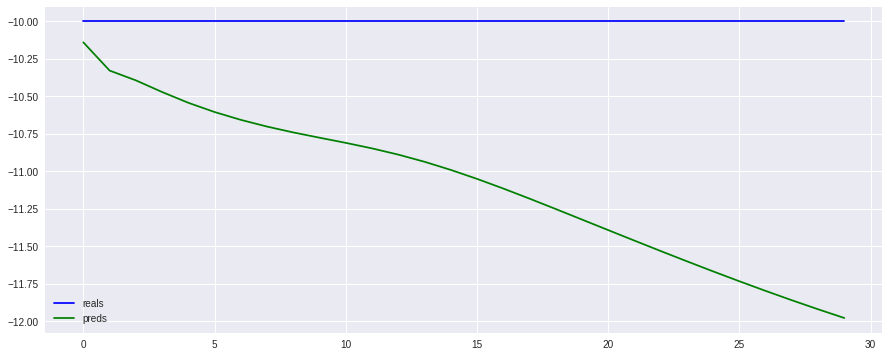

In [132]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [122]:
average_huber_loss = np.mean([np.mean(huber_loss(dp.targets[ind], preds_dict[ind]))
                              for ind in range(len(dp.targets))])
average_huber_loss

4.8119028598042517

#### Conclusion
???